In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Reddit Sentiment Analysis**

In [48]:
!pip install praw

In [49]:
import praw
from IPython import display
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import re

In [50]:
client_id = "BIOoZ_fWqSm2CA"
client_secret = "wJLDG8brQ-tnd6GGAFDUqcdGiYu9JQ"
user_agent = "scrap-redit-data"
reddit = praw.Reddit(
    client_id=client_id, 
    client_secret=client_secret, 
    user_agent=user_agent)


In [104]:
posts = []
post_topic = reddit.subreddit('JoeBiden')
for post in post_topic.new(limit=100):
    posts.append([post.title, 
                  post.score, 
                  post.id, 
                  post.subreddit, 
                  post.url, 
                  post.num_comments, 
                  post.selftext, 
                  post.created])
posts = pd.DataFrame(posts, columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])
posts.head()

,title,score,id,subreddit,url,num_comments,body,created
0,Trump rejects plan for early vaccination at Wh...,4,kcsh1o,JoeBiden,https://youtu.be/rUEoGy68dKg,3,,1.607957e+09
1,"Electoral College will vote Monday, confirming...",14,kcsbup,JoeBiden,https://www.reuters.com/article/usa-election-i...,4,,1.607956e+09
2,Soooo this is the man that caused a split in a...,1,kcrwez,JoeBiden,https://i.redd.it/jamc98rne3561.jpg,3,,1.607954e+09
3,The WSJ opinion editor is having a very public...,49,kcqoxe,JoeBiden,https://www.wsj.com/articles/the-biden-team-st...,15,,1.607949e+09
4,Dr. Biden's response to WSJ's J. Epstein.,23,kcq926,JoeBiden,https://www.reddit.com/r/TwoXChromosomes/comme...,2,,1.607948e+09


# New Post Clustering

In [122]:
top_post_reddit = posts.iloc[:, 0:2]
top_post_reddit.head()

,title,score
0,Trump rejects plan for early vaccination at Wh...,4
1,"Electoral College will vote Monday, confirming...",14
2,Soooo this is the man that caused a split in a...,1
3,The WSJ opinion editor is having a very public...,49
4,Dr. Biden's response to WSJ's J. Epstein.,23


In [123]:
sia = SIA()

top_post_reddit['sentiment'] = top_post_reddit.title.apply(lambda x: sia.polarity_scores(x)['compound'])
top_post_reddit

,title,score,sentiment
0,Trump rejects plan for early vaccination at Wh...,4,-0.5837
1,"Electoral College will vote Monday, confirming...",14,0.5859
2,Soooo this is the man that caused a split in a...,1,-0.4767
3,The WSJ opinion editor is having a very public...,49,-0.6786
4,Dr. Biden's response to WSJ's J. Epstein.,23,0.0000
...,...,...,...
95,“Opinion | Is There a Doctor in the White Hous...,42,0.0000
96,DAE feel a sense of revenge when they voted Bi...,40,-0.5267
97,Trump is acting unhinged,49,0.0000
98,That is just mean Jill,600,0.0000


In [124]:
top_post_reddit = top_post_reddit['title']
top_post_reddit

0     Trump rejects plan for early vaccination at Wh...
1     Electoral College will vote Monday, confirming...
2     Soooo this is the man that caused a split in a...
3     The WSJ opinion editor is having a very public...
4             Dr. Biden's response to WSJ's J. Epstein.
                            ...                        
95    “Opinion | Is There a Doctor in the White Hous...
96    DAE feel a sense of revenge when they voted Bi...
97                             Trump is acting unhinged
98                               That is just mean Jill
99                                               Always
Name: title, Length: 100, dtype: object

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(top_post_reddit)

model = KMeans(n_clusters=5, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=5, n_init=1)

In [142]:
copy_data = top_post_reddit.reset_index()
copy_data

,index,title
0,0,Trump rejects plan for early vaccination at Wh...
1,1,"Electoral College will vote Monday, confirming..."
2,2,Soooo this is the man that caused a split in a...
3,3,The WSJ opinion editor is having a very public...
4,4,Dr. Biden's response to WSJ's J. Epstein.
...,...,...
95,95,“Opinion | Is There a Doctor in the White Hous...
96,96,DAE feel a sense of revenge when they voted Bi...
97,97,Trump is acting unhinged
98,98,That is just mean Jill


In [143]:
print(model.labels_)
copy_data['kluster'] = model.labels_

[3 2 0 1 1 0 0 0 2 1 0 2 2 0 2 2 0 0 3 0 2 0 0 1 1 2 0 0 0 0 2 0 2 2 0 0 2
 4 2 0 0 0 0 1 0 0 1 1 2 2 3 2 1 1 0 0 0 0 0 1 3 2 0 0 0 2 2 0 2 0 0 0 0 0
 1 0 1 1 0 2 0 1 1 0 0 2 1 1 2 2 0 0 2 0 0 3 1 2 0 0]


In [157]:
print(model.cluster_centers_)

[[0.         0.         0.         ... 0.01132802 0.         0.01041175]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00590175 0.00590175 0.00590175 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.10672387 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# Headlines Sentiment Analysis

In [58]:
headlines = set()
for submission in post_topic.new(limit=100):
    headlines.add(submission.title)
    display.clear_output()
    print(headlines)

{"You'd probably find more intelligence in the bottom pic.", 'President-elect Biden will speak tomorrow night on "the electoral college vote certification and the strength and resilience of our democracy," transition says. Remarks set for about 8 p.m. ET.', 'Almost half of US voters think Trump will go down as ‘one of worst presidents in history’ says Fox poll', 'Multiple Fights Break Out During the MAGA March', 'Me to ACB after she helps to reject Trump’s Supreme Court case', "Wall Street Journal draws backlash over op-ed urging Jill Biden to drop 'doctor' title", 'Red alert for reporters: Trumpers are destroying evidence on their way out the door', 'GDP of counties that voted for Biden vs voted for Trump', "Just noticed something on my sign. Any idea why Illinois and South Dakota aren't included?", 'Trump allies in Congress to challenge election results: report', 'Alright enough is enough.', 'The Guardian view on Joe Biden: cometh the hour, cometh the man', 'Republicans plan to inves

# Labeling data

In [59]:
sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)
result_df = pd.DataFrame.from_records(results)
result_df

,neg,neu,pos,compound,headline
0,0.000,0.702,0.298,0.5256,You'd probably find more intelligence in the b...
1,0.000,0.894,0.106,0.4939,President-elect Biden will speak tomorrow nigh...
2,0.177,0.823,0.000,-0.6249,Almost half of US voters think Trump will go d...
3,0.278,0.722,0.000,-0.4019,Multiple Fights Break Out During the MAGA March
4,0.151,0.503,0.346,0.5423,Me to ACB after she helps to reject Trump’s Su...
...,...,...,...,...,...
94,0.000,1.000,0.000,0.0000,"Joe Biden, the second Catholic president"
95,0.141,0.859,0.000,-0.3182,Desperate Trump insists election is ‘not over’...
96,0.000,1.000,0.000,0.0000,Okbr wouldn’t let me post because of my accoun...
97,0.000,1.000,0.000,0.0000,"Hey, I have seen this one"


In [60]:
print("0: neutral\n1: positive\n-1: negative\n")

0: neutral
1: positive
-1: negative



In [61]:
# labeling our data compound
result_df['label'] = 0
result_df.loc[result_df['compound'] > 0.2, 'label'] = 1
result_df.loc[result_df['compound'] < -0.2, 'label'] = -1

# Result data  
result_df

,neg,neu,pos,compound,headline,label
0,0.000,0.702,0.298,0.5256,You'd probably find more intelligence in the b...,1
1,0.000,0.894,0.106,0.4939,President-elect Biden will speak tomorrow nigh...,1
2,0.177,0.823,0.000,-0.6249,Almost half of US voters think Trump will go d...,-1
3,0.278,0.722,0.000,-0.4019,Multiple Fights Break Out During the MAGA March,-1
4,0.151,0.503,0.346,0.5423,Me to ACB after she helps to reject Trump’s Su...,1
...,...,...,...,...,...,...
94,0.000,1.000,0.000,0.0000,"Joe Biden, the second Catholic president",0
95,0.141,0.859,0.000,-0.3182,Desperate Trump insists election is ‘not over’...,-1
96,0.000,1.000,0.000,0.0000,Okbr wouldn’t let me post because of my accoun...,0
97,0.000,1.000,0.000,0.0000,"Hey, I have seen this one",0


In [62]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   neg       99 non-null     float64
 1   neu       99 non-null     float64
 2   pos       99 non-null     float64
 3   compound  99 non-null     float64
 4   headline  99 non-null     object 
 5   label     99 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 4.8+ KB


In [63]:
print("Positive headlines:\n")
print(list(result_df[result_df['label'] == 1].headline[:5]))

print("\nNegative headlines:\n")
print(list(result_df[result_df['label'] == -1].headline[:5]))

Positive headlines:

["You'd probably find more intelligence in the bottom pic.", 'President-elect Biden will speak tomorrow night on "the electoral college vote certification and the strength and resilience of our democracy," transition says. Remarks set for about 8 p.m. ET.', 'Me to ACB after she helps to reject Trump’s Supreme Court case', 'Alright enough is enough.', 'Republicans plan to investigate Hunter Biden in hopes of incriminating Joe Biden and impeaching him.']

Negative headlines:

['Almost half of US voters think Trump will go down as ‘one of worst presidents in history’ says Fox poll', 'Multiple Fights Break Out During the MAGA March', "Wall Street Journal draws backlash over op-ed urging Jill Biden to drop 'doctor' title", 'Red alert for reporters: Trumpers are destroying evidence on their way out the door', 'They want “marshall law”, the insurrection act, threatened violence against SCOTUS judges and now want to “destroy the Republican party”.']


In [64]:
# value total positives and negatives
print(result_df.label.value_counts(), "\n")
print(result_df.label.value_counts(normalize=True) * 100)

 0    48
 1    33
-1    18
Name: label, dtype: int64 

 0    48.484848
 1    33.333333
-1    18.181818
Name: label, dtype: float64


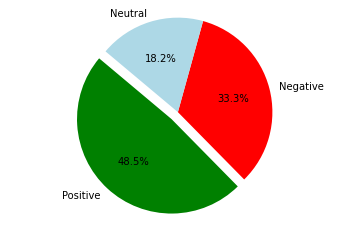

In [65]:
labels = 'Positive', 'Negative', 'Neutral'
sizes = result_df.label.value_counts()
colors = ['green', 'red', 'lightblue']
explode = (0.1, 0, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    result_df['headline'], 
    result_df['label'], 
    test_size = 0.3,random_state=0)

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer='word', stop_words='english')

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [68]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler(with_mean=False) 
scaler.fit(X_train_cv)
X_train_cv = scaler.transform(X_train_cv) 
X_test_cv = scaler.transform(X_test_cv)

In [69]:
word_freq = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
top_words_df = pd.DataFrame(word_freq.sum()).sort_values(0, ascending=False)

word_freq, top_words_df

(     12   13   35   39   50   58       5th  acb  account  accurate  ...  \
 0   0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0      0.0       0.0  ...   
 1   0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0      0.0       0.0  ...   
 2   0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0      0.0       0.0  ...   
 3   0.0  0.0  0.0  0.0  0.0  0.0  8.367479  0.0      0.0       0.0  ...   
 4   0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0      0.0       0.0  ...   
 ..  ...  ...  ...  ...  ...  ...       ...  ...      ...       ...  ...   
 64  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0      0.0       0.0  ...   
 65  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0      0.0       0.0  ...   
 66  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0      0.0       0.0  ...   
 67  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0      0.0       0.0  ...   
 68  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0      0.0       0.0  ...   
 
        white        wi  win  wisconsin       won  world  wouldn  write  wsj  \
 0   0

In [70]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_cv, y_train)
MNBpredictions = naive_bayes.predict(X_test_cv)

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy score: ', accuracy_score(y_test, MNBpredictions))
print('Precision score: ', precision_score(y_test, MNBpredictions, average='micro'))
print('Recall score: ', recall_score(y_test, MNBpredictions, average='micro'))

Accuracy score:  0.43333333333333335
Precision score:  0.43333333333333335
Recall score:  0.43333333333333335


Text(91.68, 0.5, 'Predicted label')

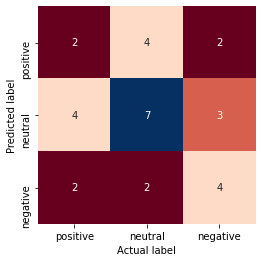

In [72]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, MNBpredictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Actual label')
plt.ylabel('Predicted label')

In [73]:

from sklearn.neighbors import KNeighborsClassifier 
KNNclassifier = KNeighborsClassifier(n_neighbors=5) 
KNNclassifier.fit(X_train_cv, y_train)

KNeighborsClassifier()

In [74]:
KNNpred = KNNclassifier.predict(X_test_cv)
print('Accuracy score: ', accuracy_score(y_test, KNNpred))

Accuracy score:  0.4666666666666667


In [75]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train_cv,y_train)

LR_Pred = lr.predict(X_test_cv)

In [76]:
score_lr = round(accuracy_score(y_test,LR_Pred)*100, 2)

print("The accuracy score achieved using Logistic Regression is: "+str(score_lr)+" %")

The accuracy score achieved using Logistic Regression is: 53.33 %


In [77]:
from sklearn import svm

sv = svm.SVC(kernel='linear')

sv.fit(X_train_cv, y_train)

SVC(kernel='linear')

In [78]:

Y_pred_svm = sv.predict(X_test_cv)
score_svm = round(accuracy_score(Y_pred_svm,y_test)*100,2)

print("The accuracy score achieved using Linear SVM is: "+str(score_svm)+" %")

The accuracy score achieved using Linear SVM is: 60.0 %
